# PART 5

previous session we built multi-layer perceptron with the following architecture

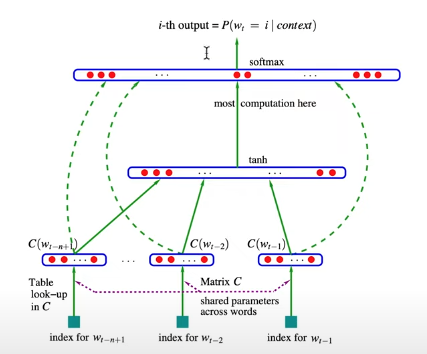

this session we want to complexify the architecture to achieve
- more words for context, not just 3
- instead of squashing all context into 1 layer, make more layers for deeper network, and gradually learned/build the relation between words

as we make the architecture more complext, this will look like a **wavenet**

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

/Users/yoshichen/miniconda3/envs/nlp-learning/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# read in all names
words = open('names.txt', 'r').read().splitlines()
print('first 10 words:\n')
print(words[:10])
print('\nlen of words: ', len(words))

first 10 words:

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']

len of words:  32033


In [4]:
# build vocab
chars = sorted(
    list( set(''.join(words) ) )
)
stoi = {s:i+1 for i, s in enumerate(chars) }
stoi['.'] = 0
itos = {i:s for s, i in stoi.items() }
print(itos)

vocab_size = len(itos)
print('vocab size: ', vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
vocab size:  27


In [5]:
import random
random.seed(42)
random.shuffle(words)

In [6]:
block_size = 3

def build_dataset(words):
    
    X, Y = [], [] # inputs, targets
    
    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context) # context words
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)

    return X, Y

In [7]:
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

# train/dev/test split
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [8]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

... --> y
..y --> u
.yu --> h
yuh --> e
uhe --> n
hen --> g
eng --> .
... --> d
..d --> i
.di --> o
dio --> n
ion --> d
ond --> r
ndr --> e
dre --> .
... --> x
..x --> a
.xa --> v
xav --> i
avi --> e


In [9]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

In [10]:
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with running momentum update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        
        # forward pass
        if self.training:
            xmean = x.mean(0,keepdim=True)
            xvar = x.var(0, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta

        # update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

In [11]:
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []

In [12]:
torch.manual_seed(42)

n_embd = 10 # emb dim
n_hidden = 200 # hidden dimension

C = torch.randn((vocab_size, n_embd))
layers = [
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
]

with torch.no_grad():
    # last layer: make less confident, so we are not `confidently wrong`
    layers[-1].weight *= 0.1

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

12097


In [13]:
def train(max_steps, batch_size, lossi, layers, parameters ):
    
    for i in range(max_steps):
        # mini batch indices
        ix = torch.randint(0, Xtr.shape[0], (batch_size,))
        Xb, Yb = Xtr[ix], Ytr[ix]
        
        # forward pass
        emb = C[Xb] # [32, 3, 2]
        x = emb.view(emb.shape[0], -1) # embedding concat based on context size
    
        for layer in layers:
            x = layer(x)
        loss = F.cross_entropy(x, Yb)
    
        # backward pass
        for p in parameters:
            # reset gradient
            p.grad = None
        loss.backward()
        
        # update: simple SGD
        lr = 0.1 if i < max_steps / 2 else 0.01 # learning rate decay
        for p in parameters:
            p.data += -lr * p.grad
    
        # track stats
        # lri.append(lre[i])
        if i % 10000 == 0:
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())

In [14]:
# training
max_steps = 200000
batch_size = 32
lossi = []

train(max_steps, batch_size, lossi, layers, parameters)


      0/ 200000: 3.2966
  10000/ 200000: 2.2322
  20000/ 200000: 2.4111
  30000/ 200000: 2.1004
  40000/ 200000: 2.3157
  50000/ 200000: 2.2104
  60000/ 200000: 1.9653
  70000/ 200000: 1.9767
  80000/ 200000: 2.6738
  90000/ 200000: 2.0837
 100000/ 200000: 2.2730
 110000/ 200000: 1.7087
 120000/ 200000: 2.3243
 130000/ 200000: 2.2512
 140000/ 200000: 2.0113
 150000/ 200000: 1.8195
 160000/ 200000: 1.7985
 170000/ 200000: 2.2206
 180000/ 200000: 2.0566
 190000/ 200000: 2.1030


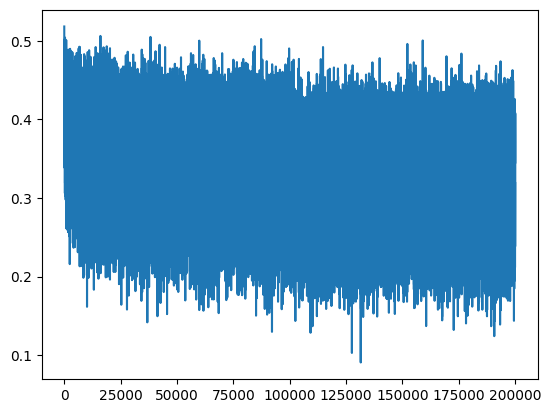

In [15]:
# loss is noisy (thick) because batch size is too small,
# we could get really lucky, or unluck depending on batch
plt.plot(lossi)

In [16]:
# put layers in eval mode, for batchNorm especially
for layer in layers:
    layer.training = False

In [17]:
# evaluate the loss
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]

    emb = C[x] # (N, block_size, n_embd)
    logits = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    for layer in layers:
        logits = layer(logits)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0621414184570312
val 2.109346389770508


In [18]:
# sample from the model to generate 20 names
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, n_embed)
        x = emb.view(emb.shape[0], -1) # concat the vector (3 words)
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift context window and track samples
        context = context[1:] + [ix]
        out.append(ix)
        # if the sample returns special token '.', stop
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

ivon.
fanili.
thoommasamiel.
emmadery.
andr.
aleigh.
kelynnie.
jazul.
carleen.
jah.
jorra.
alaya.
shonan.
vishylaharia.
juna.
vio.
orven.
meriell.
laiye.
zefina.


In [17]:
lossi[:10]

[0.5180676579475403,
 0.5164594054222107,
 0.507362961769104,
 0.507546603679657,
 0.4992470443248749,
 0.5014019012451172,
 0.5049523115158081,
 0.48866209387779236,
 0.4999050199985504,
 0.4899313449859619]

In [21]:
torch.arange(10).view(5,2)

tensor([[0, 1],
        [2, 3],
        [4, 5],
        [6, 7],
        [8, 9]])

In [24]:
# or use -1 to auto calculate the other dim
torch.arange(10).view(5,-1)

tensor([[0, 1],
        [2, 3],
        [4, 5],
        [6, 7],
        [8, 9]])

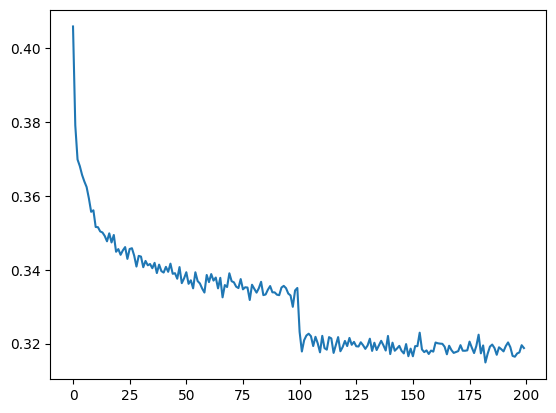

In [39]:
# now we can re-arrange our loss, to be rows of 1000, and take the avg of each row, then plot that
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

we see that the `learning rate` decay hit at step 100*1000

next thing we want to update, the `forward pass` code should also be abstracted as layers to simplify:
```
# forward pass
emb = C[Xb] # [32, 3, 2] # embedding look up based on batch Xb, extract to `Embedding` layer
x = emb.view(emb.shape[0], -1) # embedding concat based on context size, extract to `Concat` layer
```

In [23]:
class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]

In [24]:
class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out

    def parameters(self):
        return []

In [25]:
# introduce the concept of model containers to organize layers.
# for our case we can say Sequential model
class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x);
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [71]:
# construct the new layers
n_embd = 10 # emb dim
n_hidden = 200 # hidden dimension

# Sequential module
model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
    # last layer: make less confident, so we are not `confidently wrong`
    layers[-1].weight *= 0.1

parameters = model.parameters()
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

22097


In [70]:
# update train with the new layers in consideration
# we no longer need C, it will be part of layers
def train(max_steps, batch_size, lossi, model, parameters ):
    
    for i in range(max_steps):
        # mini batch indices
        ix = torch.randint(0, Xtr.shape[0], (batch_size,))
        Xb, Yb = Xtr[ix], Ytr[ix]
        
        # forward pass
        logits = model(Xb) # use model
        loss = F.cross_entropy(logits, Yb)
    
        # backward pass
        for p in parameters:
            # reset gradient
            p.grad = None
        loss.backward()
        
        # update: simple SGD
        lr = 0.1 if i < max_steps / 2 else 0.01 # learning rate decay
        for p in parameters:
            p.data += -lr * p.grad
    
        # track stats
        # lri.append(lre[i])
        if i % 10000 == 0:
            print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
        lossi.append(loss.log10().item())

In [73]:
max_steps = 200000
batch_size = 32
lossi = []

train(max_steps, batch_size, lossi, model, parameters)

      0/ 200000: 3.4636
  10000/ 200000: 2.2506
  20000/ 200000: 1.8745
  30000/ 200000: 2.5996
  40000/ 200000: 2.6026
  50000/ 200000: 2.0329
  60000/ 200000: 1.8734
  70000/ 200000: 2.0865
  80000/ 200000: 1.6904
  90000/ 200000: 1.8464
 100000/ 200000: 2.1715
 110000/ 200000: 2.0891
 120000/ 200000: 2.0226
 130000/ 200000: 1.8859
 140000/ 200000: 2.1200
 150000/ 200000: 1.7175
 160000/ 200000: 2.0945
 170000/ 200000: 2.4167
 180000/ 200000: 1.6740
 190000/ 200000: 1.5241


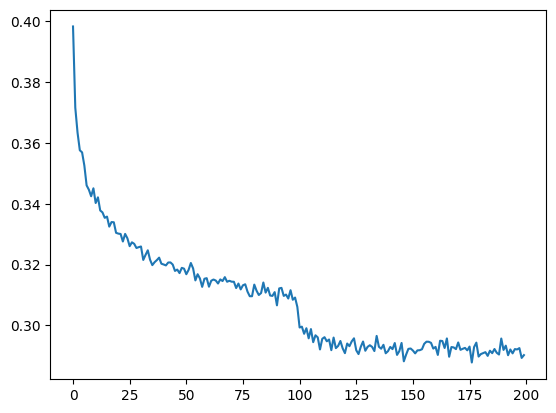

In [74]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [75]:
# now calculate overall loss like b4, 1st turn off training mode
for layer in model.layers:
    layer.training = False

In [76]:
# loss evaluaiton simplifies
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]

    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9311213493347168
val 2.031297445297241


In [77]:
# sampling also simplifies
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:

        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift context window and track samples
        context = context[1:] + [ix]
        out.append(ix)
        # if the sample returns special token '.', stop
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

khalibi.
cristyn.
ozon.
genose.
araf.
rosebot.
amad.
kanash.
omas.
shelz.
nemili.
graael.
eamonia.
zailee.
kolann.
erwing.
daque.
daedyn.
bawus.
banianny.


notice that the train/val loss are very similar
```
train 2.063701629638672
val 2.108781337738037
```

this means we are not _overfitting_ the model, otherwise training loss << validation loss.

this means we can scale our model with more layers to get better result.

our current model concat multiple characters into one layer in 1 step

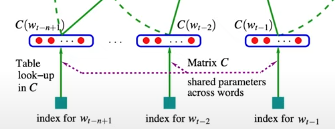

and then neural net will learn from that 1 layer.

we will achieve better result if we gradually concat/learned in hiearchical manner, like the following

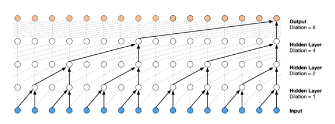

the bottom blue dots are inputs
- next hidden layer only learns from bigram pair of previous
- keep collapsing as we go deeper
- output predict the next character from all the gradual collapsing of learning

In [78]:
# to do this pair wise collapsing, lets change how dataset is built,
# we need to change the block size to 8, divisible by 2
# this means context is 8 chars, to predict the 9th char
block_size = 8

def build_dataset(words):
    
    X, Y = [], [] # inputs, targets
    
    for w in words:
        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context) # context words
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)

    return X, Y

In [79]:
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

# train/dev/test split
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [80]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [81]:
# redefine the network
n_embd = 10 # emb dim
n_hidden = 200 # hidden dimension

# Sequential module
model = Sequential([
    Embedding(vocab_size, n_embd),
    Flatten(),
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
    # last layer: make less confident, so we are not `confidently wrong`
    layers[-1].weight *= 0.1

parameters = model.parameters()
# parameter size grown because we have 8 char context now, so the 1st layer is bigger
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

22097


In [82]:
# the network should just run
max_steps = 1
batch_size = 32
lossi = []

train(max_steps, batch_size, lossi, model, parameters)

      0/      1: 3.3097


but it doesnt make sense because our context is 8 char long, we are crushing a lot of info into 1 layer

In [83]:
# but lets run it and see if it improves loss
max_steps = 200000
batch_size = 32
lossi = []

train(max_steps, batch_size, lossi, model, parameters)

      0/ 200000: 3.3696
  10000/ 200000: 2.3370
  20000/ 200000: 2.1283
  30000/ 200000: 1.9179
  40000/ 200000: 2.4459
  50000/ 200000: 2.0860
  60000/ 200000: 2.3794
  70000/ 200000: 1.7790
  80000/ 200000: 2.3208
  90000/ 200000: 2.1247
 100000/ 200000: 1.6444
 110000/ 200000: 1.9224
 120000/ 200000: 1.7809
 130000/ 200000: 1.9393
 140000/ 200000: 1.5132
 150000/ 200000: 1.5493
 160000/ 200000: 1.6570
 170000/ 200000: 2.1474
 180000/ 200000: 1.6657
 190000/ 200000: 1.9086


In [84]:
# check the overall loss
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]

    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.927162766456604
val 2.031212329864502


validation loss is improved as well, just by increasing context size.

this proves that there are a lot of room left for simple tuning.

let s now explore how to implement the hierarchal network architecture.

In [31]:
# lets only look at 4 examples, each of context size 8 (block_size)
ix = torch.randint(0, Xtr.shape[0], (4,)) # randomly pick 4 indices out of training size
Xb, Yb = Xtr[ix], Ytr[ix] # make a batch of 4
logits = model(Xb) # get the model output for the batch
print(Xb.shape) # shape of the batch
Xb

torch.Size([4, 8])


tensor([[ 0, 10, 21, 12,  9,  1, 14, 15],
        [ 0,  0,  0,  0,  0,  0,  6,  9],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0,  0, 12,  9]])

In [32]:
# look at the output shape of 1st layer
# 1st layer is embedding
# - embedding size = 10
# so [4,8,10]
model.layers[0].out.shape

torch.Size([4, 8, 10])

In [33]:
# then Flatten layer, so concat all embeddings in context: 8x10=80
model.layers[1].out.shape

torch.Size([4, 80])

In [34]:
# 3rd layer is linear, which has 200 neurons
model.layers[2].out.shape

torch.Size([4, 200])

In [35]:
# the linear layer feeds input (embedding, 80) to each neuron, there are 200 neurons, plus bias
# using random values to illustrate
(torch.randn(4,80) @ torch.randn(80, 200) + torch.randn(200)).shape

torch.Size([4, 200])

In [36]:
# notice that 1st dim is unchanged, we can have higher dimensions, as long as the last is 80
# the matrix multilication on operates on the last dim
# all the dimension in the front are batch dimensions
(torch.randn(4, 5, 6, 7, 80) @ torch.randn(80, 200) + torch.randn(200)).shape

torch.Size([4, 5, 6, 7, 200])

In [38]:
# notice that we can use the batch dim to do our hierarchy setup
#
# input context: 1 2 3 4 5 6 7 8
# we want to group: (1 2) (3 4) (5 6) (7 8), bigram input to the linear layer
# this grouping can be treated as a batch dim, and parallel process this
# so instead of (4, 80) @ (80, 200), we want bigram to the linear layer: (20, 200)
# we can do (4, 4, 20) @ (20, 200)
# 4 is batch dim
# 4 is group dim
# 20 is bigram, each with 10 emb dim
(torch.randn(4, 4, 20) @ torch.randn(20, 200) + torch.randn(200)).shape

torch.Size([4, 4, 200])

In [40]:
# this means we need to update Flatten layer to outout 4,4,20, not 4,80
# also Linear layer needs to be (20, 200)

# Flatten layer 1st
# the input to Flatten layer is
e = torch.randn(4, 8, 10) # goal: we want (4,4,20), concat bigram

# Flatten layer currently just collaps the last dim,
e.view(4, -1).shape

torch.Size([4, 80])

In [41]:
# python list of 10 numbers
list(range(10))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [42]:
# pick even indices
list(range(10))[::2]

[0, 2, 4, 6, 8]

In [44]:
# pick odd indices
list(range(10))[1::2]

[1, 3, 5, 7, 9]

In [49]:
# again the input
e.shape

torch.Size([4, 8, 10])

In [54]:
# manual concat
# step1 - [:, ::2, :], pick all batch, only pick even groups in the batch, pick all in the group
# step2 - [:, 1::2, :], pick all batch, only odd groups, pick all in the group
# step3 - concat event odd group
explicit = torch.cat(
    [
        e[:, ::2, :],
        e[:, 1::2, :]
    ], 
    # concat at the last dim, dim 2
    dim=2
)
explicit.shape

torch.Size([4, 4, 20])

In [55]:
# or in this case, we can use view() again.
# view(4,4,20) has the exact arrangements
( e.view(4,4,20) == explicit).all()

tensor(True)

In [58]:
# lets implement the new flatten behavior
class FlattenConsecutive:
    def __init__(self, n):
        # context length
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        # C is embedding size
        # T is the group dim
        # re-arrange to (B, -1, C * n), cuz concat n chars
        # to be explicit we dont want to use -1, helpful for error tracing, so
        # we use T//n (// is integer division)
        x = x.view(B, T//self.n, C * self.n)
        
        # in cast T//n=1, we will skip/squeeze the dim
        if x.shape[1] == 1:
            x = x.squeeze(1) # explicit to squeeze out the dim at index 1

        self.out = x
        return self.out

    def parameters(self):
        return []

In [85]:
# update the network, this recreats the previous setup
n_embd = 10 # emb dim
n_hidden = 200 # hidden dimension

# Sequential module
model = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(block_size), # block_size=8
    Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
    # last layer: make less confident, so we are not `confidently wrong`
    layers[-1].weight *= 0.1

parameters = model.parameters()
# parameter size grown because we have 8 char context now, so the 1st layer is bigger
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

22097


In [60]:
# look at the 4 example again
ix = torch.randint(0, Xtr.shape[0], (4,)) # randomly pick 4 indices out of training size
Xb, Yb = Xtr[ix], Ytr[ix] # make a batch of 4
logits = model(Xb) # get the model output for the batch
print(Xb.shape) # shape of the batch
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0,  0,  4,  1, 14,  9],
        [16,  5, 18,  7, 18,  1,  3,  5],
        [ 0,  0,  0,  0,  0, 19,  9, 13],
        [ 0,  0,  0,  0, 13,  1, 24, 13]])

In [61]:
# print the layer shape to make sure it s expected
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 80)
Linear : (4, 200)
BatchNorm1d : (4, 200)
Tanh : (4, 200)
Linear : (4, 27)


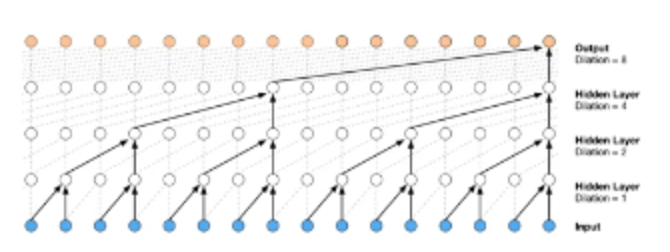

In [63]:
# --- NOW DO IT HIERACHICALLY
n_embd = 10 # emb dim
n_hidden = 200 # hidden dimension

# Sequential module
model = Sequential([
    Embedding(vocab_size, n_embd),
    # hieararchal layer 1 of bigrams
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    # hierarchal layer 2
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
     # hierarchal layer 2
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
    # last layer: make less confident, so we are not `confidently wrong`
    layers[-1].weight *= 0.1

parameters = model.parameters()
# parameter size grown because we have 8 char context now, so the 1st layer is bigger
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

170897


In [64]:
# forward the model
ix = torch.randint(0, Xtr.shape[0], (4,)) # randomly pick 4 indices out of training size
Xb, Yb = Xtr[ix], Ytr[ix] # make a batch of 4
logits = model(Xb) # get the model output for the batch
print(Xb.shape) # shape of the batch
Xb

torch.Size([4, 8])


tensor([[ 0, 11,  9, 14,  7,  4, 15, 13],
        [ 0,  0,  0, 13,  9, 12, 15, 19],
        [ 0,  0,  0,  0,  0,  0,  1, 13],
        [ 0,  0,  0,  0,  0,  0,  0,  0]])

In [65]:
# print the layer shape to make sure it s expected
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 200)
BatchNorm1d : (4, 4, 200)
Tanh : (4, 4, 200)
FlattenConsecutive : (4, 2, 400)
Linear : (4, 2, 200)
BatchNorm1d : (4, 2, 200)
Tanh : (4, 2, 200)
FlattenConsecutive : (4, 400)
Linear : (4, 200)
BatchNorm1d : (4, 200)
Tanh : (4, 200)
Linear : (4, 27)


In [111]:
# to reproduce the 3 layers, non-hierarchal setup
# which has 22097 parameters
# lets use 68 neurons, which comes out to be 22397 parameters
n_embd = 10 # emb dim
n_hidden = 68 # neurons

# Sequential module
model = Sequential([
    Embedding(vocab_size, n_embd),
    # hieararchal layer 1 of bigrams
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    # hierarchal layer 2
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
     # hierarchal layer 2
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
    # last layer: make less confident, so we are not `confidently wrong`
    layers[-1].weight *= 0.1

parameters = model.parameters()
# parameter size grown because we have 8 char context now, so the 1st layer is bigger
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

22397


In [112]:
# train using the hierarcal model, with approximate same parameters
max_steps = 200000
batch_size = 32
lossi = []

train(max_steps, batch_size, lossi, model, parameters)

      0/ 200000: 3.4855
  10000/ 200000: 2.1232
  20000/ 200000: 2.2221
  30000/ 200000: 2.0000
  40000/ 200000: 2.1913
  50000/ 200000: 2.2454
  60000/ 200000: 2.1847
  70000/ 200000: 1.9516
  80000/ 200000: 2.0481
  90000/ 200000: 2.1691
 100000/ 200000: 2.0078
 110000/ 200000: 2.0567
 120000/ 200000: 2.0205
 130000/ 200000: 2.0962
 140000/ 200000: 2.3727
 150000/ 200000: 1.7295
 160000/ 200000: 1.8048
 170000/ 200000: 1.5947
 180000/ 200000: 2.2090
 190000/ 200000: 2.4602


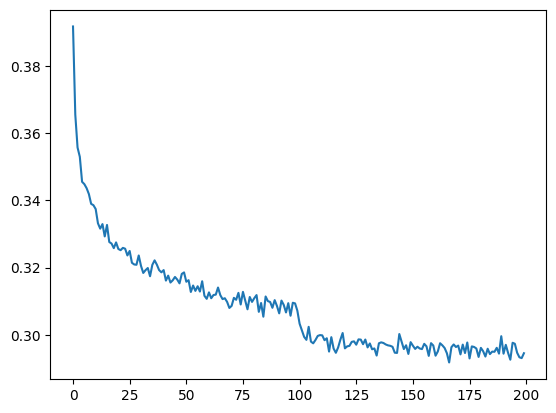

In [108]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [109]:
for layer in model.layers:
    layer.training = False
    
# check the overall loss
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]

    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9463567733764648
val 2.0322208404541016


we can see that the hierarhcal setup achieves similar perf as flat context increase to 8, nothing improved yet.

lets examine the BatchNorm layer, it runs with the new hierarchal setup, but there might be hidden bugs.

In [113]:
# inspect the layer dimension again
# print the layer shape to make sure it s expected
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (32, 8, 10)
FlattenConsecutive : (32, 4, 20)
Linear : (32, 4, 68)
BatchNorm1d : (32, 4, 68)
Tanh : (32, 4, 68)
FlattenConsecutive : (32, 2, 136)
Linear : (32, 2, 68)
BatchNorm1d : (32, 2, 68)
Tanh : (32, 2, 68)
FlattenConsecutive : (32, 136)
Linear : (32, 68)
BatchNorm1d : (32, 68)
Tanh : (32, 68)
Linear : (32, 27)


the current `BatchNorm1d` calculates _mean_ and _var_ for each sample
```
# forward pass
if self.training:
    xmean = x.mean(0,keepdim=True)
    xvar = x.var(0, keepdim=True)
else:
    xmean = self.running_mean
    xvar = self.running_var
```
the current code assumes the input is 2d, and calculates mean/var on the 1st dim.

the code is working because broadcasting applies properly, but it is not correct.

For BatchNorm, we want to
- calculate statistic for the batch
- normalizing data with batch statistics

the data is split into batches, each batch sample = `context_size * embedding_size` x `neuron_size`
we want mean/variance of all neurons for the batch, so we want to calculate mean/var for batch dim, the 1st dim.

In [117]:
# the input is now 3d
e = torch.randn(32, 4, 68)

# mean on 1st dim
# originally the expected data is 2d, so the mean is for the entire batch
# now data is 3d, we want the mean to be applied to both 1st and 2nd dim
emean = e.mean((0,1), keepdim=True) # (1,4,68)
print(emean.shape)
               
# same for variance
evar = e.var((0,1), keepdim=True) # (1,4,68)

ehat = (e - emean) / torch.sqrt(evar + 1e-5)
ehat.shape

torch.Size([1, 1, 68])


torch.Size([32, 4, 68])

In [118]:
# lets update BatchNorm impl
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with running momentum update)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        
        # forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
                
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta

        # update buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

In [119]:
# train again
n_embd = 10 # emb dim
n_hidden = 68 # neurons

# Sequential module
model = Sequential([
    Embedding(vocab_size, n_embd),
    # hieararchal layer 1 of bigrams
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    # hierarchal layer 2
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
     # hierarchal layer 2
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
    # last layer: make less confident, so we are not `confidently wrong`
    layers[-1].weight *= 0.1

parameters = model.parameters()
# parameter size grown because we have 8 char context now, so the 1st layer is bigger
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

22397


In [120]:
max_steps = 200000
batch_size = 32
lossi = []

train(max_steps, batch_size, lossi, model, parameters)

      0/ 200000: 3.4094
  10000/ 200000: 2.1285
  20000/ 200000: 2.1440
  30000/ 200000: 1.9392
  40000/ 200000: 1.9699
  50000/ 200000: 1.7173
  60000/ 200000: 2.2793
  70000/ 200000: 2.2187
  80000/ 200000: 1.6047
  90000/ 200000: 2.2673
 100000/ 200000: 1.9273
 110000/ 200000: 2.1390
 120000/ 200000: 1.8245
 130000/ 200000: 2.0648
 140000/ 200000: 1.8852
 150000/ 200000: 1.9324
 160000/ 200000: 2.0959
 170000/ 200000: 1.8927
 180000/ 200000: 1.8085
 190000/ 200000: 1.7664


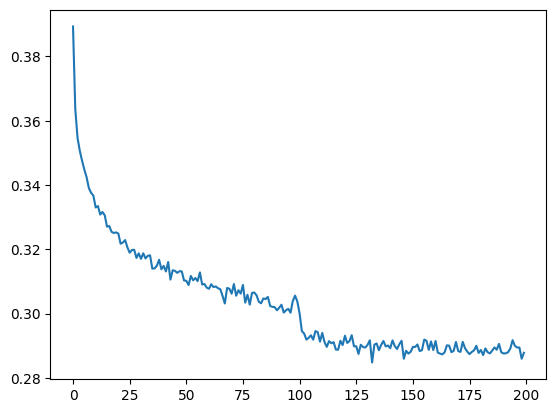

In [121]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [122]:
for layer in model.layers:
    layer.training = False
    
# check the overall loss
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]

    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.924390196800232
val 2.0263547897338867


small improvement with the batchnorm bug fixed, 2.03 -> 2.026

In [123]:
# now lets try to scale up the embedding and network size
n_embd = 24 # emb dim
n_hidden = 128 # neurons

# Sequential module
model = Sequential([
    Embedding(vocab_size, n_embd),
    # hieararchal layer 1 of bigrams
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    # hierarchal layer 2
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
     # hierarchal layer 2
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

with torch.no_grad():
    # last layer: make less confident, so we are not `confidently wrong`
    layers[-1].weight *= 0.1

parameters = model.parameters()
# parameter size grown because we have 8 char context now, so the 1st layer is bigger
print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

76579


In [124]:
max_steps = 200000
batch_size = 32
lossi = []

train(max_steps, batch_size, lossi, model, parameters)

      0/ 200000: 3.5821
  10000/ 200000: 2.5874
  20000/ 200000: 2.0961
  30000/ 200000: 1.5867
  40000/ 200000: 2.2525
  50000/ 200000: 1.8667
  60000/ 200000: 1.7324
  70000/ 200000: 2.0531
  80000/ 200000: 1.8322
  90000/ 200000: 1.9312
 100000/ 200000: 2.2168
 110000/ 200000: 2.0061
 120000/ 200000: 1.5111
 130000/ 200000: 1.9068
 140000/ 200000: 2.0589
 150000/ 200000: 1.7169
 160000/ 200000: 1.7013
 170000/ 200000: 1.6908
 180000/ 200000: 2.0151
 190000/ 200000: 1.9622


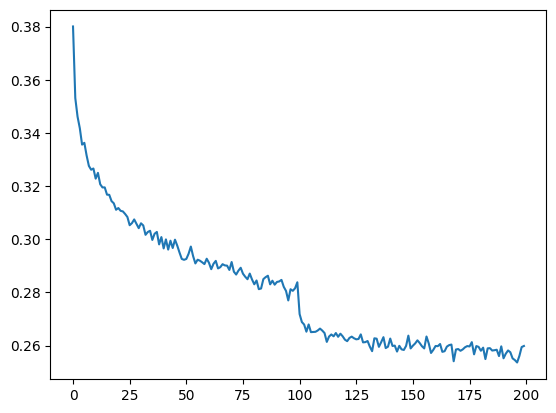

In [125]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [126]:
for layer in model.layers:
    layer.training = False
    
# check the overall loss
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]

    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7877575159072876
val 1.9933069944381714
